Determinarea numarului de clustere

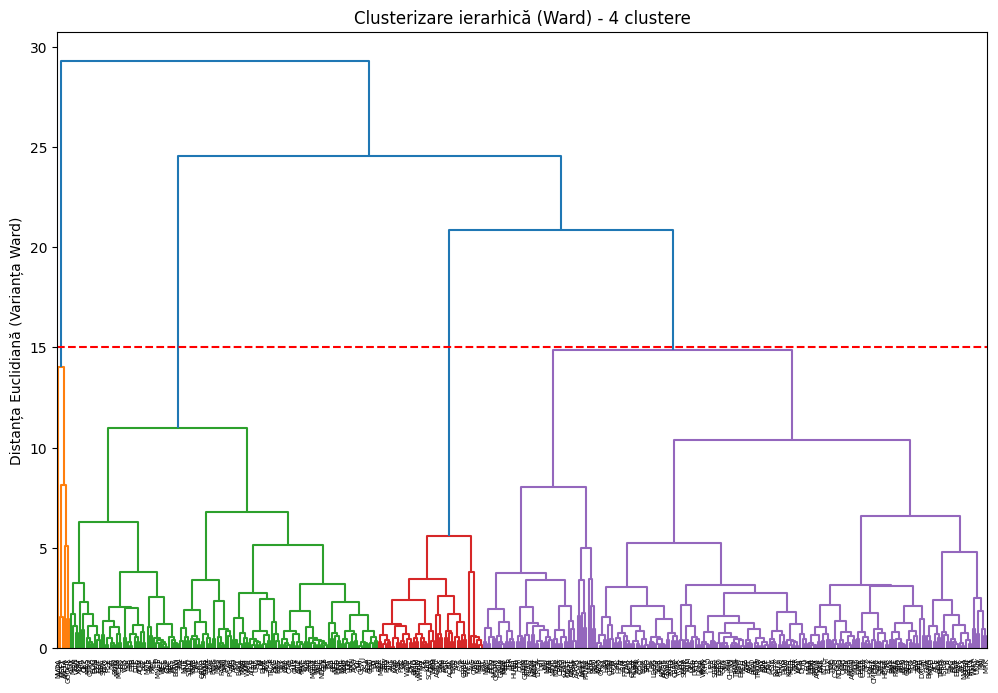

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as hclust
from scipy.cluster.hierarchy import fcluster

# 1. Pregătirea Datelor
# Variabilele au media 0.0 și deviația standard 1.0 
df_standardizat=pd.read_csv("../data/processed/date_standardizate.csv")
variabile_cheie = ['governanceScore', 'Stock_return', 'marketCap', 'environmentScore']
df = df_standardizat[variabile_cheie].values
instante = df_standardizat['Symbol'].values

# 2. Clusterizarea Ierarhică (Metoda Ward) 
h = hclust.linkage(df, method='ward') 

# 3. Determinarea Partitiei Optime (k=4) 
# Extragem etichetele pentru 4 clustere
# Scădem 1 pentru a avea indexare de la 0 la 3, conform tabelului din proiect
df_standardizat['Cluster'] = fcluster(h, t=4, criterion='maxclust') - 1

# 4. Vizualizarea Dendrogramei [cite: 54]
plt.figure(figsize=(12, 8))
plt.title("Clusterizare ierarhică (Ward) - 4 clustere")
hclust.dendrogram(
    h, 
    labels=instante, 
    color_threshold=15, # Pragul identificat pentru 4 clustere 
    leaf_rotation=90
)
plt.axhline(y=15, color='r', linestyle='--') # Linia de tăiere la pragul de 15 
plt.ylabel("Distanța Euclidiană (Varianța Ward)")
plt.show()

Profilarea clusterelor

In [ ]:

profil_clustere = df_standardizat.groupby('Cluster')[variabile_cheie].mean()


profil_clustere['Nr_companii'] = df_standardizat['Cluster'].value_counts()

print("Profilul mediu al clusterelor:")
print(profil_clustere)

Profilul mediu al clusterelor:
         governanceScore  Stock_return  marketCap  environmentScore  \
Cluster                                                               
0               0.969324      3.599598   7.493365         -0.661724   
1              -0.310498     -0.299459  -0.173344          1.136250   
2               2.056008      0.027131  -0.068628         -0.819004   
3              -0.262875      0.083653  -0.074565         -0.506185   

         Nr_companii  
Cluster               
0                  6  
1                141  
2                 48  
3                231  


Investigarea clusterului 1 (Outlierilor)


In [15]:
# Vedem cine sunt companiile din grupul foarte mic (Clusterul 1)
print("Companiile 'speciale' din Clusterul 2:")

print(df_standardizat[df_standardizat['Cluster'] == 1][['Symbol', 'Full Name', 'GICS Sector', 'Stock_return', 'governanceScore']])

Companiile 'speciale' din Clusterul 2:
    Symbol                Full Name             GICS Sector  Stock_return  \
1      AAL  American Airlines Group             Industrials     -0.842775   
8      ADI           Analog Devices  Information Technology      0.244628   
9      ADM   Archer Daniels Midland        Consumer Staples     -1.115119   
12     AEE                   Ameren               Utilities     -0.667184   
13     AEP  American Electric Power               Utilities     -0.445795   
..     ...                      ...                     ...           ...   
413     WM         Waste Management             Industrials      0.075306   
414    WMB       Williams Companies                  Energy      0.205584   
418     WY             Weyerhaeuser             Real Estate     -0.568418   
420    XEL              Xcel Energy               Utilities     -0.771269   
421    XOM               ExxonMobil                  Energy     -0.356445   

     governanceScore  
1          -0

In [16]:
import numpy as np

def diversitate(tabel,denumire_coloana=None):
    if denumire_coloana is not None:
        date=np.array(tabel.iloc[1:],dtype=float)
    else:
        date=np.array(tabel.values,dtype=float)

    suma=np.sum(date)
    proportii=date/suma

    #definire indice Shannon
    shannon=-np.sum(proportii*np.log(proportii))
    #definire indice Simpson
    simpson=1-np.sum(date/suma*date/suma)

    if denumire_coloana is not None:
        result=pd.Series([tabel.iloc[0],shannon,simpson],index=['denumire_coloana','Shannon','Simpson'])
    else:
        results = pd.Series(data=[shannon, simpson], index=['Shannon', 'Simpson'])

    return results


Analiza diversitatii pe fiecare cluster in parte 

In [ ]:

for i in sorted(df_standardizat['Cluster'].unique()):
   
    counts_cluster = df_standardizat[df_standardizat['Cluster'] == i]['GICS Sector'].value_counts()
  
    rez_div = diversitate(counts_cluster)
    
    print(f"\n--- Diversitate Sectorială Cluster {i} ---")
    print(rez_div)
    print("Top 3 sectoare în acest cluster:")
    print(counts_cluster.head(3))


--- Diversitate Sectorială Cluster 0 ---
Shannon    1.011404
Simpson    0.611111
dtype: float64
Top 3 sectoare în acest cluster:
GICS Sector
Information Technology    3
Communication Services    2
Consumer Discretionary    1
Name: count, dtype: int64

--- Diversitate Sectorială Cluster 1 ---
Shannon    1.896639
Simpson    0.836879
dtype: float64
Top 3 sectoare în acest cluster:
GICS Sector
Industrials         32
Utilities           25
Consumer Staples    24
Name: count, dtype: int64

--- Diversitate Sectorială Cluster 2 ---
Shannon    0.561865
Simpson    0.262153
dtype: float64
Top 3 sectoare în acest cluster:
GICS Sector
Financials                41
Health Care                3
Consumer Discretionary     3
Name: count, dtype: int64

--- Diversitate Sectorială Cluster 3 ---
Shannon    2.032392
Simpson    0.854744
dtype: float64
Top 3 sectoare în acest cluster:
GICS Sector
Health Care               48
Information Technology    42
Consumer Discretionary    36
Name: count, dtype: int64


Vizualizarea Hărții Clusterelor

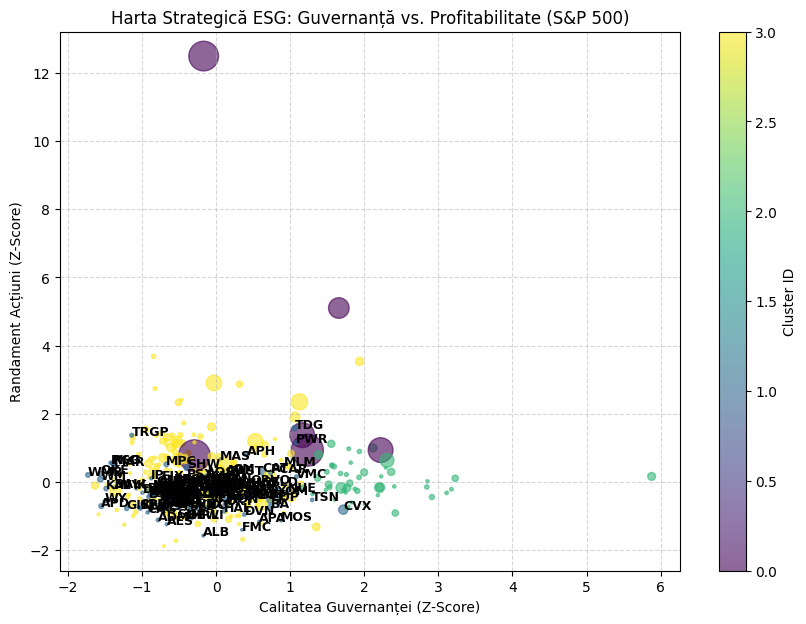

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))

# Folosim culori distincte pentru cele 4 clustere
# x = Governance, y = Stock Return
scatter = plt.scatter(df_standardizat['governanceScore'], df_standardizat['Stock_return'], 
                    c=df_standardizat['Cluster'], cmap='viridis', s=df_standardizat['marketCap']*50 + 20, alpha=0.6)

plt.title('Harta Strategică ESG: Guvernanță vs. Profitabilitate (S&P 500)')
plt.xlabel('Calitatea Guvernanței (Z-Score)')
plt.ylabel('Randament Acțiuni (Z-Score)')
plt.colorbar(scatter, label='Cluster ID')
plt.grid(True, linestyle='--', alpha=0.5)

# Adăugăm etichete pentru cei 6 giganți (Cluster 1)
for i, row in df_standardizat[df_standardizat['Cluster'] == 1].iterrows():
    plt.annotate(row['Symbol'], (row['governanceScore'], row['Stock_return']), fontsize=9, fontweight='bold')

plt.show()

In [ ]:

variabile_cheie = ['governanceScore', 'Stock_return', 'marketCap', 'environmentScore']


stats_tabel = df_standardizat[variabile_cheie].describe().transpose()



stats_tabel = stats_tabel[['count', 'mean', 'std', 'min', 'max']]
stats_tabel.columns = ['N', 'Media', 'Dev. Std.', 'Min', 'Max']


stats_tabel = stats_tabel.round(3)

print("Tabelul 1. Statistici descriptive ale variabilelor analizate (date brute)")
print(stats_tabel)



Tabelul 1. Statistici descriptive ale variabilelor analizate (date brute)
                      N  Media  Dev. Std.    Min     Max
governanceScore   426.0   -0.0        1.0 -1.728   5.878
Stock_return      426.0    0.0        1.0 -1.882  12.492
marketCap         426.0    0.0        1.0 -0.331  10.238
environmentScore  426.0   -0.0        1.0 -1.136   3.770
